In [1]:
!pip install demoji -q
!pip install  gensim -q


     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 68 kB 2.9 MB/s 


# download and unzip data

In [2]:
!wget https://zenodo.org/record/4563995/files/profner.zip?download=1 -O data.zip

--2022-09-04 10:04:10--  https://zenodo.org/record/4563995/files/profner.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46552748 (44M) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]  44.40M  19.0MB/s    in 2.3s    

2022-09-04 10:04:27 (19.0 MB/s) - ‘data.zip’ saved [46552748/46552748]



In [3]:
!unzip -q data.zip

# 1. Read data

In [4]:
import pandas as pd
import numpy as np
import os
from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
snow_stemmer = SnowballStemmer(language='spanish')
nltk.download('stopwords')
nltk.download('punkt')
stopword=stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
import demoji#remove emoji
demoji.download_codes()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  


In [7]:
train_df=pd.read_csv('profner/subtask-1/train.tsv',sep='\t')
train_df.head()

,tweet_id,label
0,1256007275807997953,0
1,1257909427677601792,0
2,1281580572415066112,0
3,1271348112733470720,0
4,1270421287148695556,0


In [8]:
val_df=pd.read_csv('profner/subtask-1/valid.tsv',sep='\t')
val_df.head()

,tweet_id,label
0,1279974120902590466,0
1,1282343525078663168,0
2,1278069425472704512,0
3,1274677343680946176,1
4,1270626757327151105,0


In [9]:
def read_text(split):
  texts_files=glob('profner/subtask-1/train-valid-txt-files/{}/*.txt'.format(split))
  texts=[]
  file_ids=[]
  for fil in texts_files:
    with open(fil,'r') as f:#read text in file
      texts.append(f.read())
    file_ids.append(fil.split('/')[-1].replace('.txt',''))#get file id
  out=pd.DataFrame(zip(file_ids,texts),columns=['tweet_id','tweet'])
  out['tweet_id']=out['tweet_id'].astype(int)#make tweet id as integer
  return out

In [10]:
train_df1=read_text('train')
train_df=train_df1.merge(train_df,on='tweet_id')
train_df.head()

,tweet_id,tweet,label
0,1251236670743158789,Ustedes las diputadas feministas no sirven par...,1
1,1269902766014713857,Te contamos cómo evitar el contagio del #Coron...,1
2,1260708906625568768,Ya sé lo que es la policía y a lo que se dedic...,1
3,1252262240847306755,"Hace falta ser indecente, Fernando Simón, para...",0
4,1292055298195193856,🦠COVID-19 GALICIA \n\n▶️ Primer fallecimiento ...,1


In [11]:
val_df1=read_text('valid')
val_df=val_df1.merge(val_df,on='tweet_id')
val_df.head()

,tweet_id,tweet,label
0,1264352810533093377,@RozalenMusic El covid-19 ... pero el hambre y...,1
1,1264668387617189895,Aquí se les ha visto la verdad de fondo: en la...,0
2,1267338256246624256,Todos los médicos de Nicaragua estamos de acue...,1
3,1291308841267863552,https://t.co/SuGRfF10Je seguid yendoós de bote...,0
4,1268445432239308800,"Por estos comportamientos, más de 20.000 compo...",1


# 2. Exploratory analysis

In [12]:
#combining both train and validation data for EDA
data=pd.concat([train_df,val_df])
data.reset_index(drop=True,inplace=True)

## Distribution of class

Text(0.5, 1.0, 'Class distribution of train data')

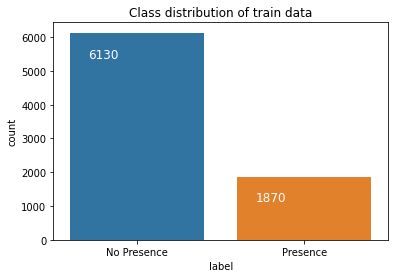

In [13]:
ax=sns.countplot(x='label',data=data)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=12)
plt.xticks(ticks=range(2),labels=['No Presence','Presence'])
plt.title('Class distribution of train data')

## tweet length distibution 

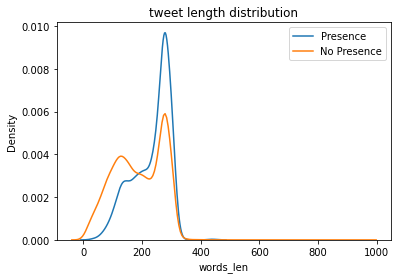

In [14]:
data['words_len']=data['tweet'].apply(lambda x: len(x))
pos=data[data['label']==1]
neg=data[data['label']==0]

sns.kdeplot(pos['words_len'],label='Presence')
sns.kdeplot(neg['words_len'],label='No Presence')
plt.title('tweet length distribution')
plt.legend()

## most common words

In [15]:
# removing stop words to get meaningul results

In [16]:
from collections import Counter
#remove stopwords and select all words with length greater than 2
words_list=[item for sublist in data['tweet'].str.split(' ') for item in sublist 
               if (item not in set(stopword)and len(item)>2)]
top = Counter(words_list)
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,coronavirus,777
1,pandemia,731
2,confinamiento,450
3,#COVID19,450
4,virus,426
5,mascarilla,421
6,Gobierno,393
7,España,356
8,crisis,329
9,Los,273


## Word cloud

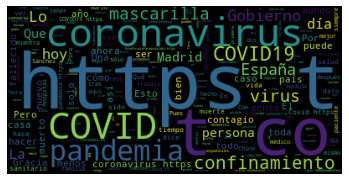

In [17]:
from wordcloud import WordCloud
wordcloud2 = WordCloud().generate(' '.join(words_list))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

# 3. Preprocessing and Normalization

In [18]:
import string
def stemmer_stopwords(sentence, language='spanish'):
  return [ snow_stemmer.stem(token) for token in nltk.word_tokenize(sentence,language=language) if token.lower() not in stopwords.words(language) ]

def remove_punctuations(sentence):
  return ' '.join(sentence).translate(str.maketrans('', '', string.punctuation))

def remove_emoji(text):
  dem = demoji.findall(text)
  for item in dem.keys():
    text = text.replace(item, " ")
  return text  

In [19]:

def clean_data(df):
  df['tweet'] = df['tweet'].str.replace(r"http\S+", '', regex=True)#remove urls
  df['tweet'] = df['tweet'].str.replace(r'@[^\s]+', '', regex=True)#remove mentions

  df['tweet']=df.tweet.apply(stemmer_stopwords)#remove stop words and do lemmatization
  df['tweet']=df.tweet.apply(remove_punctuations)#remove punctuations
  df['tweet']=df.tweet.apply(remove_emoji)#remove emoji
  df['tweet']=df['tweet'].str.replace('\d+', '')#remove digits
  df['tweet']= df['tweet'].replace(r'\s+', ' ', regex=True)#remove extra whitespaces

  return df

In [20]:
train_df=clean_data(train_df)
val_df=clean_data(val_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [21]:
#remove all with two or less than two words
train_df=train_df[train_df.tweet.str.split().apply(lambda x:len(x))>=2]
val_df=val_df[val_df.tweet.str.split().apply(lambda x:len(x))>=2]

# 4. Vectorization

In [22]:
!wget https://zenodo.org/record/1410403/files/complete_model.zip

--2022-09-04 10:06:00--  https://zenodo.org/record/1410403/files/complete_model.zip
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8513429017 (7.9G) [application/octet-stream]
Saving to: ‘complete_model.zip’

complete_model.zip  100%[===================>]   7.93G  21.8MB/s    in 11m 6s  

2022-09-04 10:17:20 (12.2 MB/s) - ‘complete_model.zip’ saved [8513429017/8513429017]



In [23]:
!unzip -q complete_model.zip

In [24]:
import gensim

# Load pre-trained Word2Vec model.
model = gensim.models.Word2Vec.load("complete.model")

In [25]:
train_df.head()

,tweet_id,tweet,label
0,1251236670743158789,usted diput femin sirv despilfarr fond public,1
1,1269902766014713857,cont com evit contagi coronavirus oficin espac...,1
2,1260708906625568768,se polic dedic sig revent dentr vist com confi...,1
3,1252262240847306755,hac falt ser indecent fern simon habl decenci ...,0
4,1292055298195193856,covid galici prim fallec juni resident trabaj...,1


In [26]:
len(model.wv.vocab),model.wv.vector_size

(1943871, 400)

In [27]:
#tokenize sentnece, then for each word get embedding if that word exisit in vocab, if it not in vocab create zero vector, finally average all vectors
x_train=np.array([np.mean([model.wv[i] if i in model.wv.vocab else np.zeros(model.wv.vector_size,) for i in j ],0) for j in  train_df.tweet.str.split()])
x_test=np.array([np.mean([model.wv[i] if i in model.wv.vocab else np.zeros(model.wv.vector_size,) for i in j ],0) for j in  val_df.tweet.str.split()])
print(x_train.shape),print(x_test.shape)

(5962, 400)
(1990, 400)


(None, None)

In [28]:
y_train=train_df.label.values
y_test=val_df.label.values

# 5.Model training and evaluation

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


In [30]:
#append all models in list
models = []
models.append(("LogisticRegression",LogisticRegression()))
models.append(("SVC",SVC()))
models.append(("LinearSVC",LinearSVC()))
models.append(("KNeighbors",KNeighborsClassifier()))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))

In [31]:
#iterate each model one by one
results = []
names = []
for name,model in models:
    result = cross_val_score(model, x_train, y_train,  cv=3)
    names.append(name)
    results.append(result)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [32]:
for i in range(len(names)):
    print(names[i],results[i].mean())

LogisticRegression 0.7952031936629002
SVC 0.8037573705949841
LinearSVC 0.7955383702989621
KNeighbors 0.7383419794053703
DecisionTree 0.6719218177712475
RandomForest 0.7802750912453416


# fine tuning

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

clf = SVC()
Cs = [ 1,2,3,5,7,10,15,30,50,70,100]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
estimator = RandomizedSearchCV(clf,
                         dict(C=Cs,gamma=gammas),cv=3,n_jobs=-1) 

results = estimator.fit( x_train, y_train)
print(results.best_score_ )


0.817176081147175


In [34]:
tuned_model=results.best_estimator_
tuned_model

SVC(C=2, gamma=0.05)

In [35]:
tuned_model.fit(x_train,y_train)
pred=tuned_model.predict(x_test)

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1513
           1       0.74      0.28      0.40       477

    accuracy                           0.80      1990
   macro avg       0.77      0.62      0.64      1990
weighted avg       0.79      0.80      0.77      1990

